### Bible Reading Progress Tracker - Data Exploration

Notebook ini digunakan untuk:
1. Load dan parse WhatsApp chat data
2. Analisis statistik dasar
3. Visualisasi pola komunikasi
4. Identifikasi pattern untuk progress reports

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import sys

# suppress warnings in notebook
warnings.filterwarnings('ignore')

# add src to path
sys.path.append('../')

from src.preprocessing.whatsapp_parser import WhatsAppParser
from src.preprocessing.bible_reference_normalizer import BibleReferenceNormalizer

# set style for plots
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)

#### 1. Load Data

In [2]:
# Load Whatsapp chat data
parser = WhatsAppParser()
normalizer = BibleReferenceNormalizer()

CHAT_FILE = Path('../data/raw/whatsapp_exports/_chat.txt')

df = parser.parse_chat_file(CHAT_FILE)
print(f'Total messages parsed: {len(df)}')
print(f'\nDataFrame shape: {df.shape}')
print(f'\nColumns: {df.columns.tolist()}')


Total messages parsed: 19032

DataFrame shape: (19032, 5)

Columns: ['date', 'time', 'sender', 'message', 'timestamp']


In [3]:
# drop columns date and time, as it is redundant
df.drop(['date', 'time'], axis=1, inplace=True)

In [4]:
# Filter system-like messages
df_clean = parser.filter_system_messages(df)
print(f'Total messages after filtering system messages: {len(df_clean)}')

Total messages after filtering system messages: 18949


In [5]:
# Display sample messages
df_clean.head(15)

,sender,message,timestamp
0,"dr. Andreas C.N., Fp.B.",Siap terimakasih sudah diadd di grup 🙏🏻,2020-08-02 11:52:41
1,Lenny Pandjidharma,sami2 ...,2020-08-02 11:52:51
2,Lenny Pandjidharma,untuk peraturan group dan tata pelaksanaan ......,2020-08-02 11:53:17
3,Oma Lisa,Thanks Lenny.t Lisa ikut ya spytdk cpt pikun a...,2020-08-02 12:20:41
4,Mfitri,"Ok,makasih ci 🙏",2020-08-02 12:22:35
5,Sim Ay Tjan,Thanks Len.🙏🏼,2020-08-02 12:51:17
6,Tjunfebelyana,Thanks Len🙏,2020-08-02 13:01:32
7,Oma Lisa,Mulak kapan dan jam brp Lenny.Gbu txs,2020-08-02 14:22:31
8,Lenny Pandjidharma,"Dimulainya besok, Tante Lisa.",2020-08-02 14:26:58
9,Oma Lisa,Ok,2020-08-02 14:37:45


#### 2. Basic Statistics

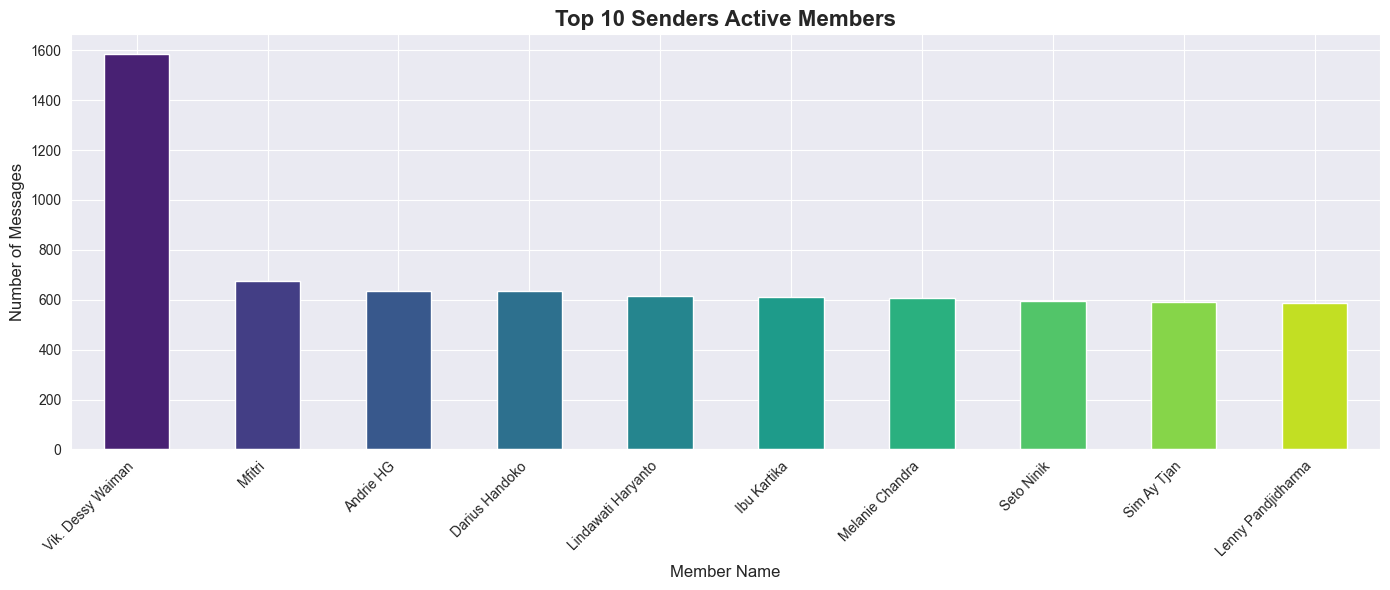

In [6]:
# Message counts by sender
sender_counts = df_clean['sender'].value_counts()

# Top 10 active members
sender_counts.head(10).plot(kind='bar', color=sns.color_palette('viridis', 10))
plt.title('Top 10 Senders Active Members', fontsize=16, fontweight='bold')
plt.xlabel('Member Name', fontsize=12)
plt.ylabel('Number of Messages', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [7]:
# Messages per day
df_clean['date_only'] = df_clean['timestamp'].dt.date
messages_per_day = df_clean.groupby('date_only').size()

print(f'\nMessages per day statistics:')
print(f'Mean: {messages_per_day.mean():.2f}')
print(f'Median: {messages_per_day.median():.2f}')
print(f'Max: {messages_per_day.max()}')
print(f'Min: {messages_per_day.min()}')


Messages per day statistics:
Mean: 27.34
Median: 28.00
Max: 83
Min: 1


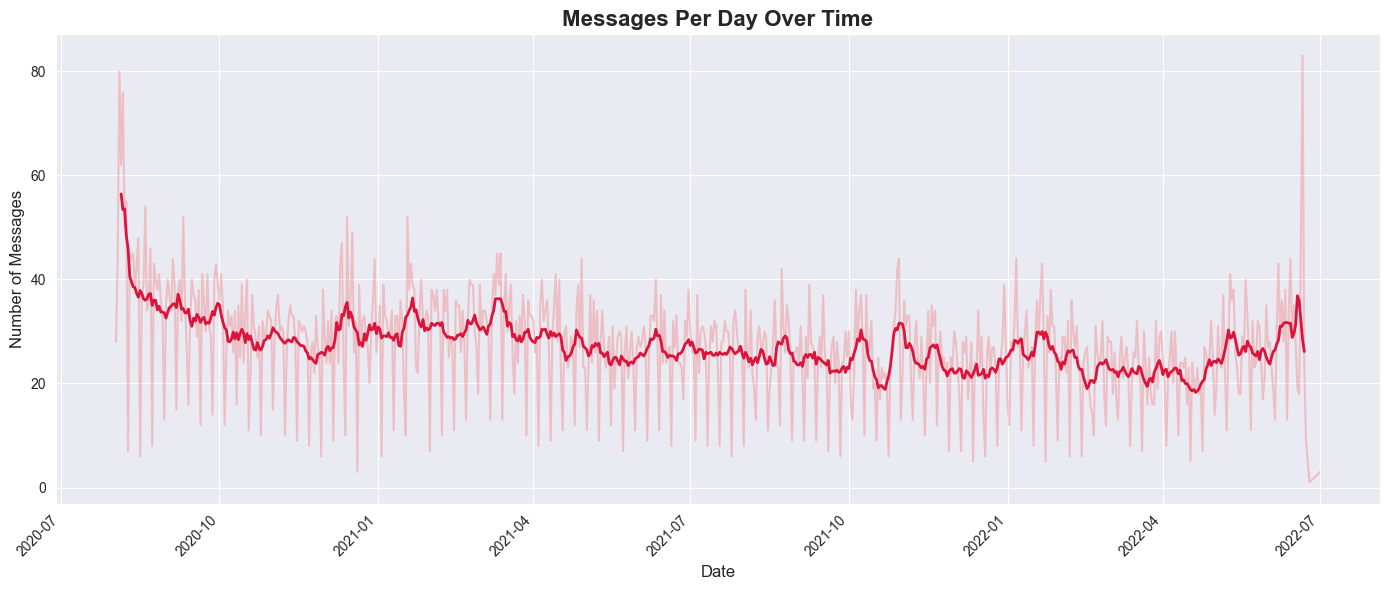

In [8]:
rolling = messages_per_day.rolling(window=7, center=True).mean()
plt.plot(messages_per_day.index, messages_per_day.values, color='lightcoral', alpha=0.4, label='Daily')
plt.plot(rolling.index, rolling.values, color='crimson', linewidth=2, label='7-Day Rolling Average')
plt.title('Messages Per Day Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Messages', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

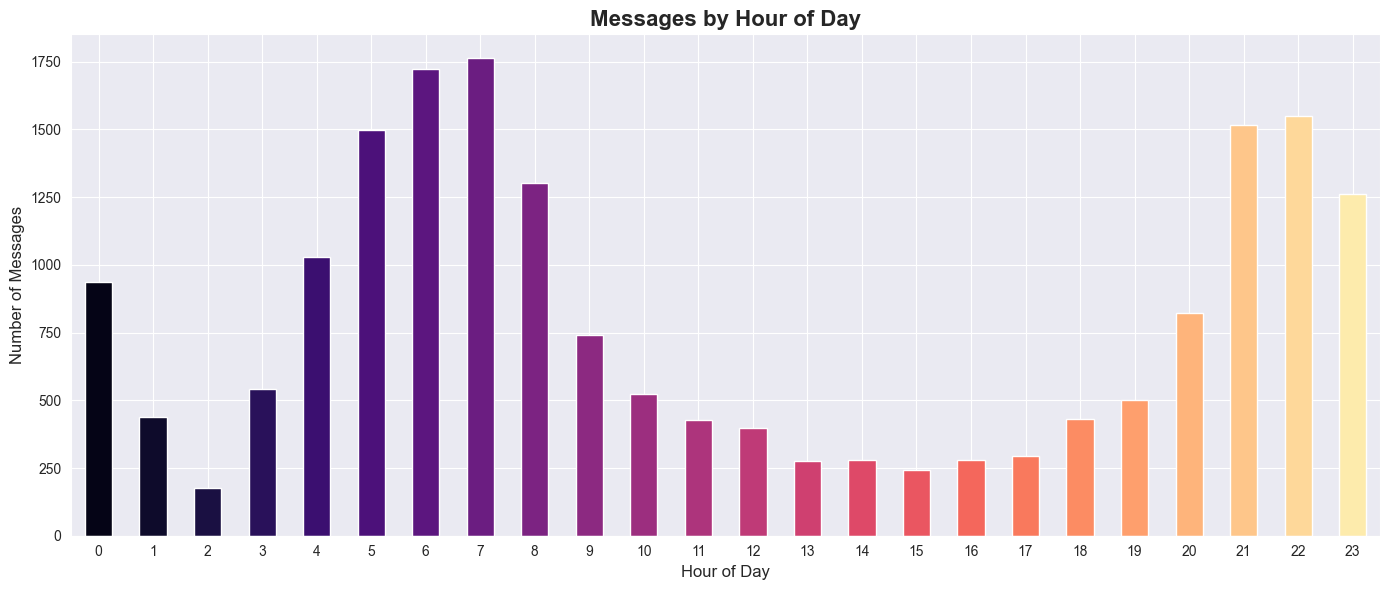

In [9]:
# Messages by hour of day
df_clean['hour'] = df_clean['timestamp'].dt.hour
messages_per_hour = df_clean['hour'].value_counts().sort_index()

messages_per_hour.plot(kind='bar', color=sns.color_palette('magma', 24))
plt.title('Messages by Hour of Day', fontsize=16, fontweight='bold')
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Number of Messages', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [10]:
# Message Length Distribution (characters)
df_clean['message_length'] = df_clean['message'].str.len()

overall_mean = df_clean['message_length'].mean()
overall_median = df_clean['message_length'].median()

print(f'\nMessage Length Statistics')
print(f'  Mean: {overall_mean:.2f}')
print(f'  Median: {overall_median:.2f}')


Message Length Statistics
  Mean: 148.65
  Median: 15.00


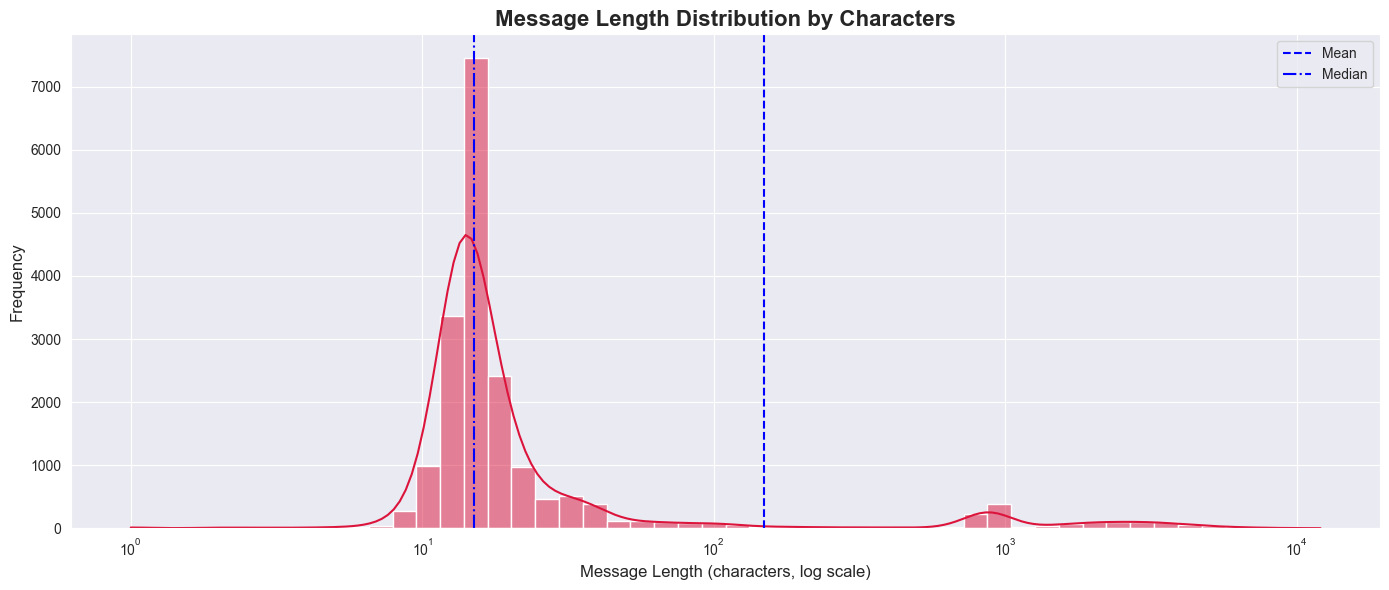

In [11]:
sns.histplot(df_clean['message_length'], bins=50, color='crimson', alpha=0.5, kde=True, log_scale=True)

plt.axvline(np.mean(df_clean['message_length']), color='blue', linestyle='--', label='Mean')
plt.axvline(np.median(df_clean['message_length']), color='blue', linestyle='-.', label='Median')

plt.title('Message Length Distribution by Characters', fontsize=16, fontweight='bold')
plt.xlabel('Message Length (characters, log scale)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
# Number of lines per message
df_clean['num_lines'] = df_clean['message'].str.count('\n') + 1

overall_lines_mean = df_clean['num_lines'].mean()
overall_lines_median = df_clean['num_lines'].median()

print(f'\nNumber of Lines per Message:')
print(f'  Mean: {overall_lines_mean:.2f}')
print(f'  Median: {overall_lines_median:.2f}')


Number of Lines per Message:
  Mean: 3.92
  Median: 1.00


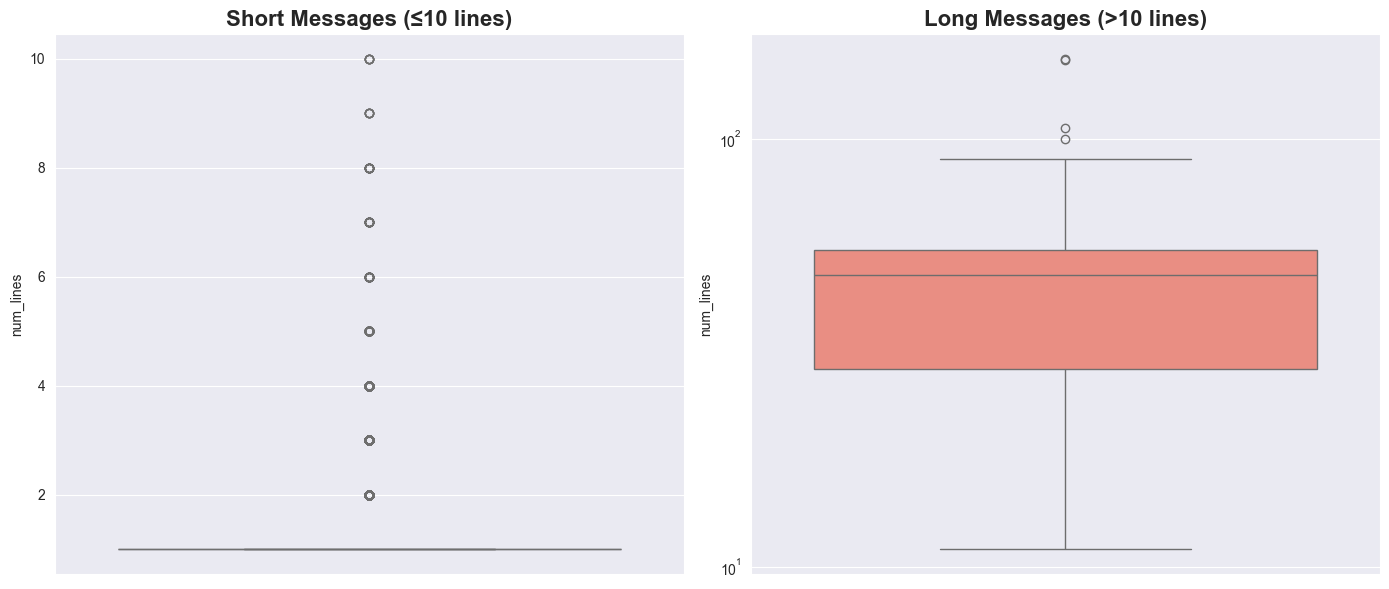

In [13]:
plt.subplot(1, 2, 1)
sns.boxplot(y=df_clean[df_clean['num_lines'] <= 10]['num_lines'], color='skyblue')
plt.title('Short Messages (≤10 lines)', fontsize=16, fontweight='bold')


plt.subplot(1, 2, 2)
sns.boxplot(y=df_clean[df_clean['num_lines'] > 10]['num_lines'], color='salmon')
plt.title('Long Messages (>10 lines)', fontsize=16, fontweight='bold')

plt.yscale('log')

plt.tight_layout()
plt.show()

#### 3. Identify Progress Reports

In [14]:
progress_keywords = ['done', 'selesai', 'sudah', 'finish', '✓', '✅', '☑', '💥']

df_clean['has_progress_keyword'] = df_clean['message'].str.lower().apply(
    lambda x: any(kw in x for kw in progress_keywords)
)

print(f'Message with progress keywords')
print(f'Total: {df_clean["has_progress_keyword"].sum()} out of {len(df_clean)} messages')
print(f'Percentage: {df_clean["has_progress_keyword"].sum() / len(df_clean) * 100:.2f}%')

Message with progress keywords
Total: 16419 out of 18949 messages
Percentage: 86.65%


In [15]:
print('\nSample Messages with Progress Keywords:')
df_clean[df_clean['has_progress_keyword']][['sender', 'message']].head(10)


Sample Messages with Progress Keywords:


,sender,message
0,"dr. Andreas C.N., Fp.B.",Siap terimakasih sudah diadd di grup 🙏🏻
13,Vik. Dessy Waiman,*Introduksi Kitab Kejadian*\n\n*Judul*\n\nTuha...
16,Vik. Dessy Waiman,"Selamat malam bpk, ibu, sdr, sdri,\nSelamat be..."
18,Vik. Dessy Waiman,"**Bible Reading Cycle 2, 3 Agst 2020**\n\n*📖 G..."
23,Vik. Dessy Waiman,"Selamat malam bpk, ibu, sdr, sdri,\nSelamat be..."
24,Vik. Dessy Waiman,*Introduksi Kitab Kejadian*\n\n*Judul*\n\nTuha...
26,Vik. Dessy Waiman,"**Bible Reading Cycle 2, 3 Agst 2020**\n\n*📖 G..."
28,Melanie Chandra,Kej 1-2 done
29,Lindawati Haryanto,Kej 1-2 done
30,Sherly Cahyadi,Kej 1-2 done


In [16]:
# Extract bible references
def extract_bible_ref(message):
    refs = normalizer.extract_all_references(message)
    if refs:
        return ', '.join(ref['normalized_text'] for ref in refs)
    return None

df_clean['bible_reference'] = df_clean['message'].apply(extract_bible_ref)
df_clean['has_bible_ref'] = df_clean['bible_reference'].notna()

print(f'Messages with Bible References')
print(f'Total: {df_clean['has_bible_ref'].sum()}')
print(f'Percentage: {df_clean["has_bible_ref"].sum() / len(df_clean) * 100:.2f}%')

print(normalizer.get_stats())

Messages with Bible References
Total: 15224
Percentage: 80.34%
{'exact_match': 14905, 'fuzzy_match': 2451, 'failed': 1919}


In [17]:
# Sample messages with bible references
print('\nSample Messages with Bible References:')
df_clean[df_clean['has_bible_ref']][['sender', 'message', 'bible_reference']].head(10)


Sample Messages with Bible References:


,sender,message,bible_reference
13,Vik. Dessy Waiman,*Introduksi Kitab Kejadian*\n\n*Judul*\n\nTuha...,Amsal 37-50
16,Vik. Dessy Waiman,"Selamat malam bpk, ibu, sdr, sdri,\nSelamat be...","Kejadian 1-2, Kejadian 1-2"
18,Vik. Dessy Waiman,"**Bible Reading Cycle 2, 3 Agst 2020**\n\n*📖 G...","Kejadian 1-2, Ayub 18-25"
23,Vik. Dessy Waiman,"Selamat malam bpk, ibu, sdr, sdri,\nSelamat be...","Kejadian 1-2, Kejadian 1-2"
24,Vik. Dessy Waiman,*Introduksi Kitab Kejadian*\n\n*Judul*\n\nTuha...,Amsal 37-50
26,Vik. Dessy Waiman,"**Bible Reading Cycle 2, 3 Agst 2020**\n\n*📖 G...","Kejadian 1-2, Ayub 18-25"
28,Melanie Chandra,Kej 1-2 done,Kejadian 1-2
29,Lindawati Haryanto,Kej 1-2 done,Kejadian 1-2
30,Sherly Cahyadi,Kej 1-2 done,Kejadian 1-2
31,Seto Ninik,Kej 1-2 done,Kejadian 1-2


In [18]:
# Identify likely progress reports 
df_clean['likely_progress'] = (
    df_clean['has_progress_keyword'] & df_clean['has_bible_ref']
)

print(f'Likely Progress Reports')
print(f'Total: {df_clean['likely_progress'].sum()}')
print(f'Percentage: {df_clean["likely_progress"].sum() / len(df_clean) * 100:.2f}%')

Likely Progress Reports
Total: 13961
Percentage: 73.68%


In [19]:
# Sample likely progress reports
print('\nSample Likely Progress Reports:')
df_clean[df_clean['likely_progress']][['sender', 'message']].head(15)


Sample Likely Progress Reports:


,sender,message
13,Vik. Dessy Waiman,*Introduksi Kitab Kejadian*\n\n*Judul*\n\nTuha...
16,Vik. Dessy Waiman,"Selamat malam bpk, ibu, sdr, sdri,\nSelamat be..."
18,Vik. Dessy Waiman,"**Bible Reading Cycle 2, 3 Agst 2020**\n\n*📖 G..."
23,Vik. Dessy Waiman,"Selamat malam bpk, ibu, sdr, sdri,\nSelamat be..."
24,Vik. Dessy Waiman,*Introduksi Kitab Kejadian*\n\n*Judul*\n\nTuha...
26,Vik. Dessy Waiman,"**Bible Reading Cycle 2, 3 Agst 2020**\n\n*📖 G..."
28,Melanie Chandra,Kej 1-2 done
29,Lindawati Haryanto,Kej 1-2 done
30,Sherly Cahyadi,Kej 1-2 done
31,Seto Ninik,Kej 1-2 done


#### 4. Pattern Analysis

In [20]:
# Message length analysis 
df_clean['message_length'] = df_clean['message'].str.len()

# Compare length between progress and non-progress messages
progress_lengths = df_clean[df_clean['likely_progress']]['message_length']
non_progress_lengths = df_clean[~df_clean['likely_progress']]['message_length']

print(f'\nMessage Length Statistics')
print(f'\nProgress reports:')
print(f'  Mean: {progress_lengths.mean():.2f}')
print(f'  Median: {progress_lengths.median():.2f}')

print(f'\nNon-Progress reports:')
print(f'  Mean: {non_progress_lengths.mean():.2f}')
print(f'  Median: {non_progress_lengths.median():.2f}')


Message Length Statistics

Progress reports:
  Mean: 60.27
  Median: 14.00

Non-Progress reports:
  Mean: 396.03
  Median: 19.00


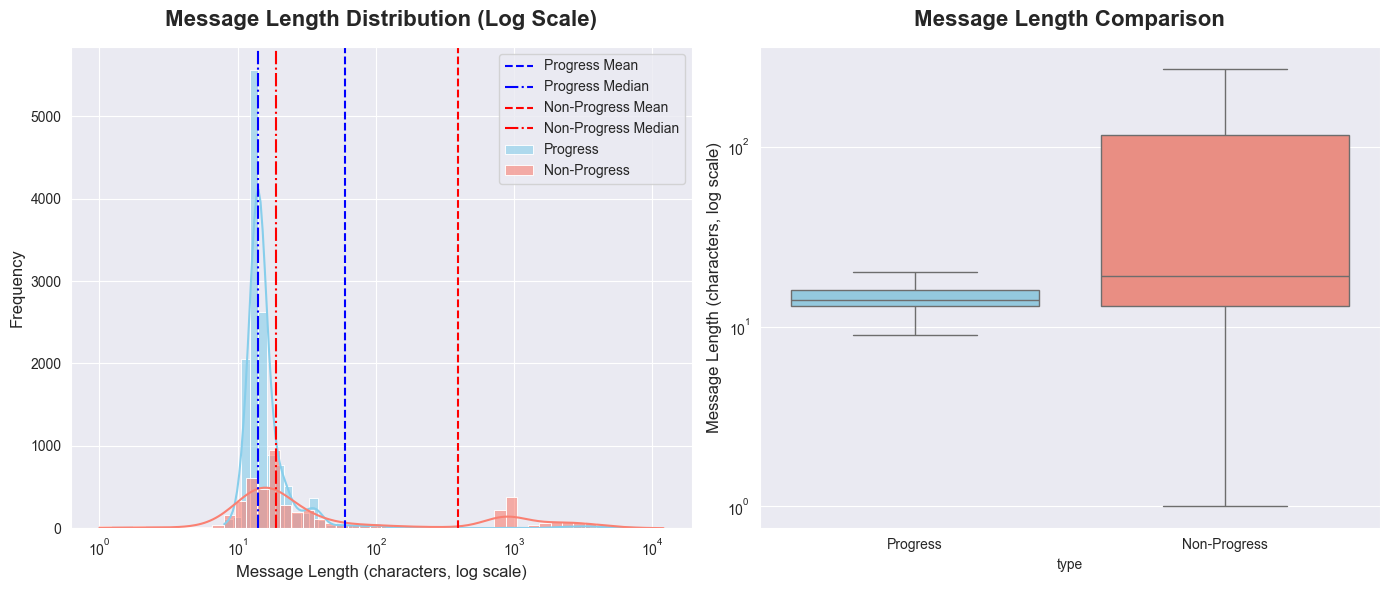

In [21]:

plt.subplot(1, 2, 1)
sns.histplot(progress_lengths, bins=50, color='skyblue', alpha=0.6, label='Progress', kde=True, log_scale=True)
sns.histplot(non_progress_lengths, bins=50, color='salmon',alpha=0.6, label='Non-Progress', kde=True, log_scale=True)

plt.axvline(np.mean(progress_lengths), color='blue', linestyle='--', label='Progress Mean')
plt.axvline(np.median(progress_lengths), color='blue', linestyle='-.', label='Progress Median')

plt.axvline(np.mean(non_progress_lengths), color='red', linestyle='--', label='Non-Progress Mean')
plt.axvline(np.median(non_progress_lengths), color='red', linestyle='-.', label='Non-Progress Median')

plt.title('Message Length Distribution (Log Scale)', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Message Length (characters, log scale)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()

df_box = pd.DataFrame({
    'message_length': np.concatenate([progress_lengths, non_progress_lengths]),
    'type': ['Progress'] * len(progress_lengths) + ['Non-Progress'] * len(non_progress_lengths)
})

plt.subplot(1, 2, 2)
sns.boxplot(data=df_box, x='type', y='message_length', palette={'Progress': 'skyblue', 'Non-Progress': 'salmon'}, showfliers=False)
plt.yscale('log')
plt.xticks([0, 1], ['Progress', 'Non-Progress'])
plt.title('Message Length Comparison', fontsize=16, fontweight='bold', pad=15)
plt.ylabel('Message Length (characters, log scale)', fontsize=12)
plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()

In [22]:
# Progress by Members
progress_by_member = df_clean[df_clean['likely_progress']].groupby('sender').size().sort_values(ascending=False)

print(f'Progress Reports by Members (Top 20)')
progress_by_member.head(20)

Progress Reports by Members (Top 20)


sender
Lindawati Haryanto          568
Ci Ina Paperku              549
Darius Handoko              547
Seto Ninik                  546
Andrie HG                   531
Ivan teguh                  521
susianawati309              521
🎍                           510
Nurcahaya Sihombing         507
Melanie Chandra             504
Lenny Pandjidharma          502
Dewi Pratiwi                497
Mfitri                      471
Sim Ay Tjan                 470
Ruri Handoko                466
Kristin WIjaya Nusantara    420
Endang Surati               406
Agnes                       378
Tjunfebelyana               349
🪸Martha 🍁                   308
dtype: int64

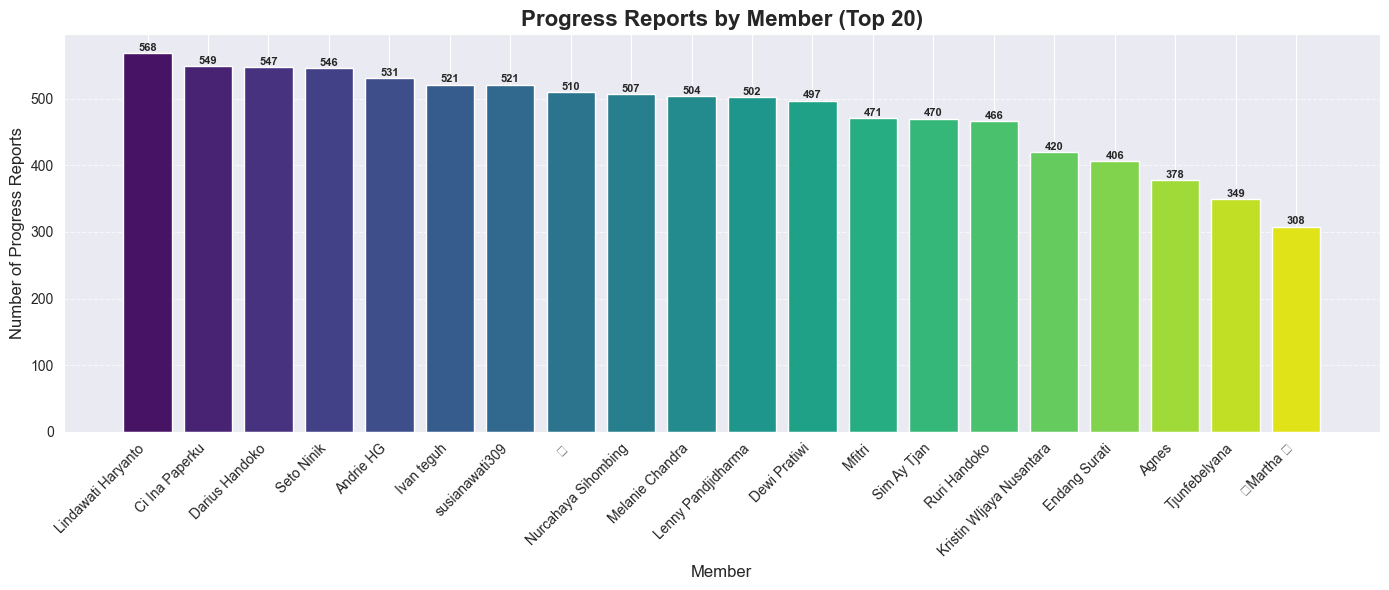

In [23]:
bars = plt.bar(progress_by_member.head(20).index,
               progress_by_member.head(20).values,
               color=sns.color_palette('viridis', 20))

plt.title('Progress Reports by Member (Top 20)', fontsize=16, fontweight='bold')
plt.xlabel('Member', fontsize=12)
plt.ylabel('Number of Progress Reports', fontsize=12)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{int(height)}',
             ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()